In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator, array_to_img, save_img
import numpy as np
import pandas as pd
import os
# import seaborn as sns
from functools import partial
# sns.set_context('notebook')
# sns.set_style('white')
import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)
session = tf.compat.v1.InteractiveSession(config=config)


# config.log_device_placement = True  # to log device placement (on which device the operation ran)
#                                     # (nothing gets printed in Jupyter, only if you run it standalone)
# config.gpu_options.per_process_gpu_memory_fraction = 0.2
# config.gpu_options.allow_growth = True


Num GPUs Available:  1


Test GPU TensorFLow

In [2]:
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [3]:
my_dir = os.getcwd()  # grabs current work dir
all_file_paths = os.listdir()  # grabs all items in current work dir

data_path = [data for data in all_file_paths if 'traindata_pp' in data.lower()]  # searches for data folder and retrieves


picture_folder_path = os.path.join(my_dir, data_path[0])  # joins data folder and current work dir to get picture path
all_pictures = os.listdir(picture_folder_path)  # list of pictures names in folder

picture_complete_path = [os.path.join(picture_folder_path, pic) for pic in
                         all_pictures]  # complete path to each picture

img_1 = load_img(picture_complete_path[0])
print("FIRST IMAGE DETAILS:", "\nClass: ", type(img_1), "\nFile Format: ", img_1.format,
      "\nImage type: ", img_1.mode, '\nImage Size:', img_1.size)
print()

Color_message = '*' * 15 + ' IMPORTING RGB Images ' + '*' * 15

print(Color_message)
rgb_scale_photos = [load_img(photo, color_mode='rgb') for photo in picture_complete_path] # RGB


# print()

array_message = '*' * 15 + ' Converting Images to Arrays ' + '*' * 15
print(array_message)


array_photo_list = [img_to_array(photo) for photo in rgb_scale_photos] # RGB
del rgb_scale_photos

X_train_all = np.asarray(array_photo_list)
X_train_all[:, :,:,0] /= 255.0  # normalizes images
del array_photo_list

# del rgb_scale_photos, array_photo_list


FIRST IMAGE DETAILS: 
Class:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 
File Format:  JPEG 
Image type:  RGB 
Image Size: (640, 480)

*************** IMPORTING RGB Images ***************
*************** Converting Images to Arrays ***************


In [4]:
# plt.imshow(X_train_all[0][:,:,0],cmap='gray')
# plt.imshow(array_photo_list[0][:,:,:].astype(np.uint8))   #OK??????
# plt.show()


In [5]:
copies = int(X_train_all.shape[0] / 1025)  # how many copies of original data set. Augmentiaton copies = copies- 1
print(copies)

# read in CSV as pandas DF
df_y = pd.read_csv('TrainAnnotations.csv')

# strip annotation column and convert to numpy
Y_train_1_copy = df_y['annotation'].to_numpy()  # original data labels

Y_train_all = [Y_train_1_copy for i in range(copies)]  # multiply data labels
Y_train_all = np.asarray(Y_train_all)  # convert list of data labels into 2D array
Y_train_all = Y_train_all.flatten()  # flatten 2D array into 1D array


# index position describes numeric values
y_labels = ['No Wilting', 'Leaflets folding inward at secondary pulvinus, no turgor loss in leaflets or petioles',
            'Slight leaflet or petiole turgor loss in upper canopy', 'Moderate turgor loss in upper canopy',
            'Severe turgor loss throughout canopy']



3


<center>  Histogram of Underlying Y Label Distribution </center>

<center> Highly unbalanced </center>

In [6]:
# df_y.describe()
# sns.distplot(Y_train_all, kde=False, bins=5)
# plt.show()
X_train_all[0].shape[0]

480

In [7]:
DefaultConv2D = partial(keras.layers.Conv2D,kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=11, input_shape=[X_train_all[0].shape[0],X_train_all[0].shape[1], 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.2),
#     keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
    ])

In [8]:
model.summary()
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 480, 640, 64)      23296     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 240, 320, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 320, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 320, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 120, 160, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 160, 256)     295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 60, 80, 256)       0

In [9]:
history = model.fit(X_train_all[1025:1025*2], Y_train_all[1025:1025*2], epochs=15, validation_split=0.15, batch_size=16)

Train on 871 samples, validate on 154 samples
Epoch 1/15
871/871 [==============================] - 54s 62ms/sample - loss: 160.4886 - accuracy: 0.3617 - val_loss: 1.5230 - val_accuracy: 0.5195
Epoch 2/15
871/871 [==============================] - 49s 57ms/sample - loss: 1.7007 - accuracy: 0.4122 - val_loss: 1.5511 - val_accuracy: 0.5195
Epoch 3/15
871/871 [==============================] - 52s 59ms/sample - loss: 1.6141 - accuracy: 0.4168 - val_loss: 1.4368 - val_accuracy: 0.5195
Epoch 4/15
871/871 [==============================] - 52s 59ms/sample - loss: 1.6175 - accuracy: 0.4145 - val_loss: 1.3990 - val_accuracy: 0.5195
Epoch 5/15
871/871 [==============================] - 52s 60ms/sample - loss: 1.5034 - accuracy: 0.4351 - val_loss: 1.3742 - val_accuracy: 0.5130
Epoch 6/15
871/871 [==============================] - 53s 61ms/sample - loss: 1.4250 - accuracy: 0.4627 - val_loss: 1.4056 - val_accuracy: 0.4935
Epoch 7/15
871/871 [==============================] - 53s 60ms/sample - loss

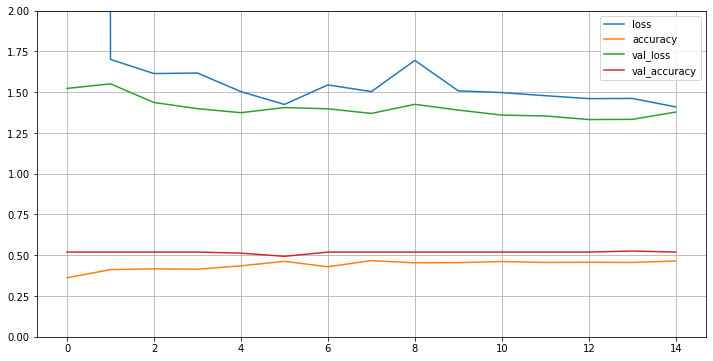

In [10]:
pd.DataFrame(history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [11]:
tf.keras.backend.clear_session() 

In [12]:
Y_train_all[1025]

0

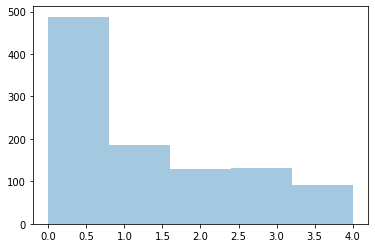

In [13]:
import seaborn as sns
sns.distplot(Y_train_all[0:1025],kde = False,bins=5)